In [1]:
#Important Libaries Required:

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import random
from copy import deepcopy
import time
import math
import numpy as np
#import matplotlib.pyplot as plt
import findspark
findspark.init()
import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc
from pyspark.sql import functions as F
#from pyspark.context import SparkContext
#from pyspark.sql.session import SparkSession
sc= SparkContext(appName="my_app", master= "local[1]") 

#sc is spark context object used to tell spark how to access the cluster. 
#we pass configuration parameters in sc i.e. app name, and master(cluster URL) which are application parameters.


%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
#matplotlib.style.use('ggplot')
from pyspark.ml import Pipeline
#from pyspark.ml.feature import StringIndexer
from pyspark.sql import functions as F
#from pyspark.sql.functions import udf
from pyspark.sql.types import *
from graphframes import *
from graphframes import GraphFrame

import sys
#print(sys.path)
#pip install pyspark==3.0.0
#spark-submit --version
#Spark version 3.1.2
#pip install graphframes



''' Refer below link to install PySpark -'''
#https://changhsinlee.com/install-pyspark-windows-jupyter/

'''Refer below steps to install latest version of graphframe module after PySpark installion:- '''
##1. Check the spark version installed by using below command in command prompt-
#spark-submit --version
#1. Check the version of graphframe from below link which is suitable for installed Spark version and install it-
#    https://spark-packages.org/package/graphframes/graphframes


#2. Copy the jar file to the location where python is installed in Spark(python folder in the installed spark) 

#3. Copy the jar file to spark location as a zip file. refer below sample command, which can be run in window power shell-
#    cp 'C:\\Users\\XXXXX\\AppData\\Local\\Programs\\Spark\\spark-3.1.2-bin-hadoop2.7\\jars\\graphframes*.jar' 
#    'C:\\Users\\XXXXX\\AppData\\Local\\Programs\\Spark\\spark-3.1.2-bin-hadoop2.7\\python\\graphframes.zip'

#4. Unzip it and cut items present in the same subfolder folder and paste them in outer folder name graphframe folder.

#5. Add the new path in the environmental variables. Refer sample below-
#    C:\Users\XXXXX\AppData\Local\Programs\Spark\spark-3.1.2-bin-hadoop2.7\python\graphframes\

#6. Return to jupyter notebook and refresh it.Then, run -
#from graphframe import *


"""
#JAVA INSTALLATION DETAILS:-
C:\Windows\system32>java -version
java version "1.8.0_301"
Java(TM) SE Runtime Environment (build 1.8.0_301-b09)
Java HotSpot(TM) 64-Bit Server VM (build 25.301-b09, mixed mode)

Spark Version: spark-3.1.2-bin-hadoop2.7
https://mirrors.estointernet.in/apache/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
"""



##graphframe jar file path:
#"C:\\Users\\...\\Programs\\Spark\\spark-3.1.2-bin-hadoop2.7\\jars\\graphframes*.jar"
#"C:\\Users\\...\\Programs\\Spark\\spark-3.1.2-bin-hadoop2.7\\graphframes.zip"

#graphframes-0.8.1-spark3.0-s_2.12

'\n#JAVA INSTALLATION DETAILS:-\nC:\\Windows\\system32>java -version\njava version "1.8.0_301"\nJava(TM) SE Runtime Environment (build 1.8.0_301-b09)\nJava HotSpot(TM) 64-Bit Server VM (build 25.301-b09, mixed mode)\n\nSpark Version: spark-3.1.2-bin-hadoop2.7\nhttps://mirrors.estointernet.in/apache/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz\n'

In [2]:
 ''' Load the scrapped 'matches data', Data Preprocessing and extract the required information '''
    

#Matches_data.csv is a scrapped data from www.espncricinfo.com
testdf = pd.read_csv("C:\\...\\deepenv\\Cricket World Cup 2019 Analysis\\playersdata\\Matches_data.csv")
print("\nMatches Data Top Few Observations:\n")
display(testdf)


Matches Data Top Few Observations:



,Match_No,Match_date,Batting_team,Ball_no,Bowler,Batsmen,Runs,commentary
0,1st match,May 30 2019,ENG,NaN,NaN,NaN,NaN,NaN
1,1st match,May 30 2019,ENG,49.6,Rabada,Plunkett,1,"Rabada to Plunkett, 1 run, full again, can onl..."
2,1st match,May 30 2019,ENG,49.5,Rabada,Plunkett,2,"Rabada to Plunkett, 2 runs, fired in towards t..."
3,1st match,May 30 2019,ENG,49.4,Rabada,Archer,1,"Rabada to Archer, 1 run, pitched up and whippe..."
4,1st match,May 30 2019,ENG,49.3,Rabada,Archer,2,"Rabada to Archer, 2 runs, fullish, 86mph and f..."
...,...,...,...,...,...,...,...,...
28746,Final,Jul 14 2019,ENG,0.5,Boult,Bairstow,0,"Boult to Bairstow, no run, looks to flick, bal..."
28747,Final,Jul 14 2019,ENG,0.4,Boult,Bairstow,0,"Boult to Bairstow, no run, back of a length, h..."
28748,Final,Jul 14 2019,ENG,0.3,Boult,Bairstow,0,"Boult to Bairstow, no run, fullish, fourth-stu..."
28749,Final,Jul 14 2019,ENG,0.2,Boult,Roy,1,"Boult to Roy, 1 run, full again, more off-stum..."


In [3]:
""" UseCase1 - Identify Strong & Weak Partnership of a player using Graph Analytics"""

'''
Steps - 

1. Data Preparation from Matches_data.csv data(scrapped file - Matches_data.csv)
2. Generate Partnership Score data. Consume it as edges in graph analysis
3. Generate batsmen score data. Consume it as vertices in graph analysis 
4. Use Graph Frame to get the near and far partners from a player in terms of partnership scores.
5. Are there team where batting partnerships did not stand longer? Analysis.

'''

"UseCase1.Step1 - Data Preprocessing Phase[Matches_data.csv]"

testdf1 = testdf.drop(['commentary'], axis=1)
testdf1 = testdf1.dropna()
testdf1['runs'] = testdf1['Runs'].astype(str).str[0]
testdf1['extras_type'] = testdf1['Runs'].astype(str).str[1:]
testdf1 = testdf1.replace(r'^\s*$', np.nan, regex=True)

#Split by delimiter(.) for Over column and introduce two columns- over and ball  --> 
testdf1[['over','ball']] = testdf1['Ball_no'].astype(str).str.split('.', expand=True)
testdf1['wicket'] = np.where(testdf1['runs'] == "W", 1, 0)
matchdata = testdf1.drop(['Ball_no', 'Runs'], axis=1)
matchdata['over'] = matchdata['over'].astype(np.int64)
matchdata['ball'] = matchdata['ball'].astype(np.int64)
matchdata['wicket'] = matchdata['wicket'].astype(np.int64)
del testdf1

matchdata.runs.replace(['W'], ['0'], inplace= True)
matchdata["runs"] = matchdata["runs"].astype('int64')
matchdata['Match_No'] = matchdata['Match_No'].str[0:5]
matchdata['datetime'] = pd.to_datetime(matchdata['Match_date'], dayfirst = True)
matchdata['month'] = matchdata['datetime'].apply(lambda x: x.strftime('%b')) 
matchdata['date'] = matchdata['datetime'].apply(lambda x: x.strftime('%d'))


matchnumber = {'1st m': 1, '2nd m': 2, '3rd m': 3,'4th m': 4, '5th m': 5, '6th m': 6, '7th m': 7, 
         '8th m': 8, '9th m': 9, '10th ': 10, '12th ': 12, '13th ': 13, '14th ': 14, '15th ': 15,
         '17th ': 17, '19th ': 19, '20th ': 20, '21st ': 21, '22nd ': 22, '23rd ': 23, '24th ': 24,
         '25th ': 25, '26th ': 26, '27th ': 27, '28th ': 28, '29th ': 29, '30th ': 30, '31st ': 31,
         '32nd ': 32, '33rd ': 33, '34th ': 34, '35th ': 35, '36th ': 36, '37th ': 37, '38th ': 38,
         '39th ': 39, '40th ': 40, '41st ': 41, '42nd ': 42, '43rd ': 43, '44th ': 44, '45th ': 45,
         '1st S': 46, '2nd S': 47, 'Final': 48} 
matchdata.Match_No = [matchnumber[i] for i in matchdata.Match_No] 


matchdata1 = matchdata.sort_values(['Match_No', 'over'], ascending=[True, True])
matchdata1 = matchdata1[(matchdata1['extras_type'] != 'w') & (matchdata1['extras_type'] != 'lb') & (matchdata1['extras_type'] != 'b') & (matchdata1['extras_type'] != 'nb')]

print("Preprocessed Matches Data (top 5 observations)")
display(matchdata1)

Preprocessed Matches Data (top 5 observations)


,Match_No,Match_date,Batting_team,Bowler,Batsmen,runs,extras_type,over,ball,wicket,datetime,month,date
352,1,May 30 2019,ENG,Imran Tahir,Root,0,NaN,0,6,0,2019-05-30,May,30
353,1,May 30 2019,ENG,Imran Tahir,Root,0,NaN,0,5,0,2019-05-30,May,30
354,1,May 30 2019,ENG,Imran Tahir,Root,0,NaN,0,4,0,2019-05-30,May,30
355,1,May 30 2019,ENG,Imran Tahir,Root,0,NaN,0,3,0,2019-05-30,May,30
356,1,May 30 2019,ENG,Imran Tahir,Bairstow,0,NaN,0,2,1,2019-05-30,May,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28395,48,Jul 14 2019,ENG,Boult,Stokes,0,NaN,49,5,1,2019-07-14,Jul,14
28396,48,Jul 14 2019,ENG,Boult,Stokes,6,NaN,49,4,0,2019-07-14,Jul,14
28397,48,Jul 14 2019,ENG,Boult,Stokes,6,NaN,49,3,0,2019-07-14,Jul,14
28398,48,Jul 14 2019,ENG,Boult,Stokes,0,NaN,49,2,0,2019-07-14,Jul,14


In [24]:
""" UseCase1.Step2 -Generate Partnership Score data. Consider Partnership Scores as edges in graph analysis below"""

## Baseline Code for finding partnership scores ##
matchno = []
batting_team = []
batsmen1 = []
batsmen2 = []
run_partnership = []
#len(matchdata1.Match_No.unique())
for i in range(0,len(matchdata1.Match_No.unique())):
    team0 = matchdata1[(matchdata1["Match_No"] == matchdata1["Match_No"].unique()[i])] 
    for j in range(0, len(team0.Batting_team.unique())):
        team1 = team0[(team0["Batting_team"] == team0["Batting_team"].unique()[j])]
        team2 = team1.sort_values(['over', 'ball'], ascending=[True, True])
        team2['dummyinteger'] = range(0,team2.shape[0])
        if team2[team2['wicket'] == 1].shape[0] == 0:
            matchno.append(team2.Match_No.unique()[0])
            batting_team.append(team2.Batting_team.unique()[0])
            batsmen1.append(team2.Batsmen.unique()[0])
            batsmen2.append(team2.Batsmen.unique()[1])
            run_partnership.append(sum(team2.runs)) 
        else:
            dummyinteger_index = team2.loc[team2['wicket'] == 1, 'dummyinteger']
            if not dummyinteger_index.empty:
                test0 = team2[(team2['dummyinteger'] >= 0) & (team2['dummyinteger'] <= dummyinteger_index.iloc[0])]
                if not test0.empty:
                    matchno.append(test0.Match_No.unique()[0])
                    batting_team.append(test0.Batting_team.unique()[0].strip())
                    if (len(test0.Batsmen.unique()) == 1):
                        batsmen1.append("NA")
                        batsmen2.append("NA")
                        #batsmen1.append(test0.Batsmen.unique()[0].strip()
                    else:
                        batsmen1.append(test0.Batsmen.unique()[0].strip())
                        batsmen2.append(test0.Batsmen.unique()[1].strip())
                    run_partnership.append(sum(test0.runs))
            
                for k in range(0, len(dummyinteger_index)-1):
                    test1 = team2[(team2['dummyinteger'] > dummyinteger_index.iloc[k]) & (team2['dummyinteger'] <= dummyinteger_index.iloc[k+1])]
                    if not test1.empty:
                        matchno01 = test1.Match_No.unique()[0]
                        matchno.append(matchno01)
                        batting_team01 = test1.Batting_team.unique()[0].strip()
                        batting_team.append(batting_team01)
                        if (len(test1.Batsmen.unique()) == 1):
                            batsmen1.append("NA")
                            batsmen2.append("NA")
                            #batsmen01 = test1.Batsmen.unique()[0].strip()
                        else:
                            batsmen01 = test1.Batsmen.unique()[0].strip()
                            batsmen1.append(batsmen01)
                            batsmen02 = test1.Batsmen.unique()[1].strip()
                            batsmen2.append(batsmen02)
                        run_partnership01 =  sum(test1.runs)
                        run_partnership.append(run_partnership01)

                test2 = team2[(team2['dummyinteger'] > dummyinteger_index.iloc[len(dummyinteger_index)-1])]
                if not test2.empty:
                    matchno.append(test2.Match_No.unique()[0])
                    batting_team.append(test2.Batting_team.unique()[0].strip())
                    if (len(test2.Batsmen.unique()) == 1):
                        batsmen1.append("NA")
                        batsmen2.append("NA")
                        #batsmen1.append(test2.Batsmen.unique()[0].strip())
                    else:
                        batsmen1.append(test2.Batsmen.unique()[0].strip())
                        batsmen2.append(test2.Batsmen.unique()[1].strip())
                    run_partnership.append(sum(test2.runs))


partnership_score = pd.DataFrame(list(zip(matchno, batting_team, batsmen1, batsmen2, run_partnership)), columns =['matchno', 'batting_team', 'batsmen1', 'batsmen2', 'run_partnership'])
#partnership_score.sort_values(['run_partnership'], ascending=[False])


print("\nPartnership Score Between Players(top 25 observations)")
display(partnership_score)


#Write file to use in graph analysis -
#partnership_score.to_excel("PartnershipScore.xlsx")


""" UseCase1.Step3- Generate Batsmen Score data from preprocessed data of matches. 
    We will treat Batsman total score as vertices in graph"""

batsmenscore = pd.DataFrame(matchdata1.groupby(['Batsmen']).agg({'runs': np.sum})).reset_index()
batsmenscore.columns = ['id', 'runs'] # since in vertices, first column should name as "id"
batsmenscore['id'] = batsmenscore['id'].str.strip()
print("\nbatsmen score data(top 25 observations)")
display(batsmenscore)

#batsmenscore.to_excel("batsmenscore11.xlsx")


Partnership Score Between Players(top 25 observations)


,matchno,batting_team,batsmen1,batsmen2,run_partnership
0,1,ENG,Roy,Bairstow,1
1,1,ENG,Root,Roy,104
2,1,ENG,Morgan,Root,4
3,1,ENG,Stokes,Morgan,104
4,1,ENG,Stokes,Buttler,30
...,...,...,...,...,...
720,48,ENG,Stokes,Woakes,7
721,48,ENG,Stokes,Plunkett,17
722,48,ENG,Stokes,Archer,7
723,48,ENG,NA,NA,12



batsmen score data(top 25 observations)


,id,runs
0,Aftab Alam,14
1,Ali,75
2,Allen,51
3,Ambris,36
4,Amla,209
...,...,...
144,de Grandhomme,189
145,de Kock,321
146,de Silva,108
147,du Plessis,388


In [25]:
""" UseCase1.Step4 -Use Graph Frame to get the close and far association between players in 
terms of partnership scores"""

### Graph Analysis on Partnership Data -######

'''
Vertex DataFrame: A vertex DataFrame should contain a special column named 'id' which specifies unique IDs 
for each vertex in the graph.
Edge DataFrame: An edge DataFrame should contain two special columns: 'src' (source vertex ID of edge) 
and 'dst' (destination vertex ID of edge).

'''

sqlContext = SQLContext(sc) 
'''
The entry point into all relational functionality in Spark is the SQLContext class, 
or one of its decedents. To create a basic SQLContext, all we need is a SparkContext which is 'sc' passed in SQLContext().
'''

'''
we obtained parternship score above (partnership_score) from scrapped data of matches (Matches_data.csv)
''' 
# Load the partnership data file using SQL Context
#df = sqlContext.read.load("file:/home/cloudera/practicumm2/PartnershipScore.csv",format='com.databricks.spark.csv',header='true',inferSchema='true')
df = sqlContext.createDataFrame(partnership_score)
print("partnership_score dataframe(top 25 observations)")
df.show(25)

#create temporary view as partnership-
df.createOrReplaceTempView("partnership")

#Use Graph Frame to fetch good, average and below average partnerships 
    ##that a batsmen estabilished with other batsmens in world cup -
# 1. create edges dataframe
# 2. create vertices dataframe
# 3. create graph frame with edges and vertices as input



###EDGES
## 1. create edge dataframe - Group by Batsmen1 and Batsmen2 and compute their total partnership scores
partnership_runs = sqlContext.sql("SELECT batsmen1, batsmen2, SUM(run_partnership) as partnership_runs FROM partnership GROUP BY batsmen1, batsmen2")
#Edges
edges = partnership_runs
#edges.columns = ['src', 'dst', 'partnership_runs']
edges = edges.selectExpr("batsmen1 as src", "batsmen2 as dst", "partnership_runs as partnership")

print("\nedges :: partnership run between players(top 25 observations)-")
edges.show(25)

print("\nedges schema:\n")
edges.printSchema()
#edges.show(25)



###VERTICES
#as per the UseCase1.Step3, we will consider batsmen score data as vertices. Details are as follows
# Load the batsmen score data using SQL Context
#df1 = sqlContext.read.load("file:/home/cloudera/practicumm2/batsmenscore.csv",format='com.databricks.spark.csv',header='true',inferSchema='true')

df1 = sqlContext.createDataFrame(batsmenscore)
#df1['id'] = df1['id'].str.strip()
print("\n\nbatsmenscore dataframe(top 25 observations)")
df1.show(25)


#df1.filter("id = 'Chahal'").show()
df1.createOrReplaceTempView("individual_runs")
# Group by ids to get sum of scores - motive is to create a single 
    ##entry of a particular batsmen and its total runs scored-
individual_player_runs_scored = sqlContext.sql("SELECT id, SUM(runs) as runs_scored FROM individual_runs GROUP BY id")
#Vertices -
vertices = individual_player_runs_scored

print("\nvertices :: each batsman runs(top 25 observations)-")
vertices.show()

print("\nvertices schema:\n")
vertices.printSchema()
#edges.show(25)

partnership_score dataframe(top 25 observations)
+-------+------------+---------------+---------------+---------------+
|matchno|batting_team|       batsmen1|       batsmen2|run_partnership|
+-------+------------+---------------+---------------+---------------+
|      1|         ENG|            Roy|       Bairstow|              1|
|      1|         ENG|           Root|            Roy|            104|
|      1|         ENG|         Morgan|           Root|              4|
|      1|         ENG|         Stokes|         Morgan|            104|
|      1|         ENG|         Stokes|        Buttler|             30|
|      1|         ENG|            Ali|         Stokes|             12|
|      1|         ENG|         Woakes|         Stokes|             20|
|      1|         ENG|         Stokes|       Plunkett|             15|
|      1|         ENG|       Plunkett|         Archer|             11|
|      1|          SA|        de Kock|           Amla|             36|
|      1|          SA|     d

Dhoni Partnership with Other:-

+-----+--------------+-----------+
|src  |dst           |partnership|
+-----+--------------+-----------+
|Dhoni|Kohli         |87         |
|Dhoni|Pandya        |20         |
|Dhoni|Mohammed Shami|1          |
|Dhoni|Pant          |35         |
|Dhoni|Sharma        |72         |
+-----+--------------+-----------+



Others Partnership with Dhoni:-

+-------------+-----+-----------+
|src          |dst  |partnership|
+-------------+-----+-----------+
|Kuldeep Yadav|Dhoni|16         |
|Karthik      |Dhoni|21         |
|Kohli        |Dhoni|13         |
|Jadeja       |Dhoni|109        |
|Pandya       |Dhoni|107        |
|Kumar        |Dhoni|13         |
|Jadhav       |Dhoni|93         |
+-------------+-----+-----------+


Dhoni Partnership Score Card-


,src,dst,partnership
0,Dhoni,Jadeja,109
1,Dhoni,Jadhav,93
2,Dhoni,Karthik,21
3,Dhoni,Kohli,100
4,Dhoni,Kuldeep Yadav,16
5,Dhoni,Kumar,13
6,Dhoni,Mohammed Shami,1
7,Dhoni,Pandya,127
8,Dhoni,Pant,35
9,Dhoni,Sharma,72


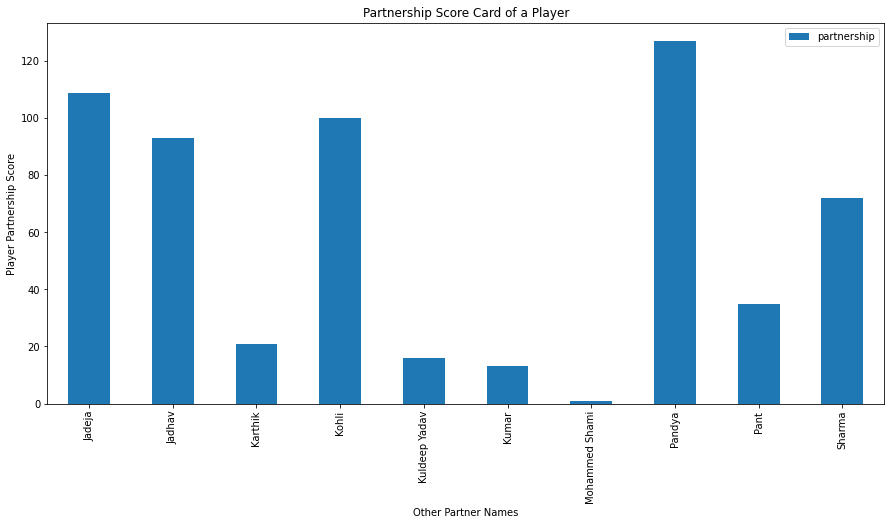

In [26]:
g = GraphFrame(vertices, edges)

#AS AN EXAMPLE, LET US TAKE PLAYER NAME- DHONI AND SEE HIS PARTNERSHIP WITH OTHERS.

#below figure is an illustration of the g.find() function. As we see, column a and b are vertices.
#and column e displays the partnership score between the player a and b.

'in the below code, a and b are vertices, whereas [e] is edge'
dhoni_with_others = g.find("(a)-[e]->(b)").filter("e.partnership > 0").filter("a.id= 'Dhoni'")
dhoni_with_others = dhoni_with_others.select("e.src", "e.dst", "e.partnership")
print("Dhoni Partnership with Other:-\n")
dhoni_with_others.show(truncate=0)
dhoni_with_others = dhoni_with_others.toPandas()
dhoni_with_others = pd.DataFrame(dhoni_with_others)

#below figure is an illustration of the g.find() function. As we see, column a and b are vertices.
#and column e displays the partnership score between the player a and b.
others_with_dhoni = g.find("(a)-[e]->(b)").filter("e.partnership > 0").filter("b.id= 'Dhoni'")
others_with_dhoni = others_with_dhoni.select("e.src", "e.dst", "e.partnership")
print("\n\nOthers Partnership with Dhoni:-\n")
others_with_dhoni.show(truncate=0)
others_with_dhoni = others_with_dhoni.toPandas()
others_with_dhoni = pd.DataFrame(others_with_dhoni)
others_with_dhoni.columns = ['dst','src', 'partnership']
others_with_dhoni = others_with_dhoni[['src','dst', 'partnership']]
dhoni_overall_partnership_score=dhoni_with_others.append(others_with_dhoni)



dhoni_overall_partnership_scr = pd.DataFrame(dhoni_overall_partnership_score.groupby(['src', 'dst']).agg({'partnership': np.sum})).reset_index()
print("\nDhoni Partnership Score Card-")
display(dhoni_overall_partnership_scr)



dhoni_overall_partnership_scr.plot(kind="bar", x="dst", y=["partnership"], 
                                   xlabel = 'Other Partner Names', 
                                   ylabel='Player Partnership Score',
                                   title='Partnership Score Card of a Player',
                                   figsize=(15,7))

plt.legend()
plt.show()


In [ ]:

'''Above plot depicts that batsman- Dhoni had a good partnership with Pandya followed by Jadeja followed by Kohli. However, 
he had weak partnership with Shami and Karthik.
'''

<AxesSubplot:title={'center':'Teams with their Batting Partnerships Break Counts'}, xlabel='Counts of breaks in batting partnerships', ylabel='Team Name'>

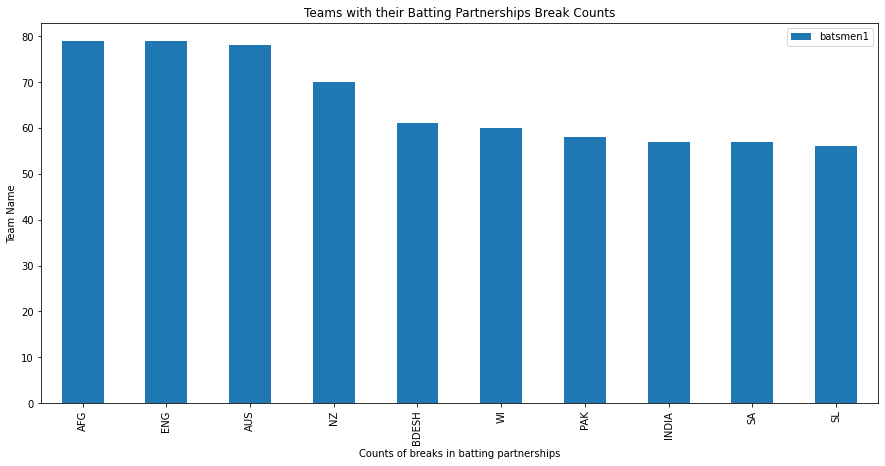

In [64]:
""" UseCase1.Step5- Are there team where batting partnerships did not stand longer? Analysis."""

dup1 = partnership_score[partnership_score.batsmen1 < partnership_score.batsmen2]
dup2 = partnership_score[partnership_score.batsmen1 > partnership_score.batsmen2]
#z = partnership_score[partnership_score.batsmen1 == partnership_score.batsmen2] # we are not considering it since, its all NANs
dup=dup1.append(dup2)
partnership_score1 = pd.DataFrame(dup.groupby(['matchno', 'batting_team','batsmen1', 'batsmen2']).sum().reset_index())


""" fetch team whose players had frequent break up in partnership"""

#Subset batting team, batsmen1 and batsmen2 from partnership score data & get team with max part. breaks -
paircount = partnership_score1[['batting_team', 'batsmen1', 'batsmen2']]
paircount
teams_with_partnership_breaks= paircount.groupby('batting_team').count().sort_values(by=['batsmen1'], ascending=False).reset_index()
#note there are no duplicates in it as data is in the order batsman played

teams_with_partnership_breaks.plot(kind="bar", x="batting_team", y=["batsmen1"], 
                                   xlabel = 'Counts of breaks in batting partnerships', 
                                   ylabel='Team Name',
                                   title='Teams with their Batting Partnerships Break Counts',
                                   figsize=(15,7))

In [ ]:
#Few points on scope of improvement:-
'''

1. Further utilities of GraphFrames which can be thought of -
    - We can automate this approach of partnership score of any player? 
    - We can include more data from other world cups to make fine estimations?
    - How many times a player has bowled out an another player?

2. We can look and have analysis more in depth on the teams where batting partnerships did not stand longer. 
    -Is there any particular player order missing in them?

'''

In [ ]:
#References:


'How to install and invoke pyspark in windows environment -'
#https://changhsinlee.com/install-pyspark-windows-jupyter/

#https://www.apache.org/dyn/closer.lua/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz

#https://graphframes.github.io/graphframes/docs/_site/user-guide.html
#https://spark.apache.org/docs/1.6.1/sql-programming-guide.html